# 22.46 Procesamiento Adaptativo de Señales Aleatorias
# **Trabajo Practico 2**
### Filtrado lineal óptimo 

**Group 1:** Sofia Yanes Sanchez and Marco Zaiser

**Date:** 24.09.2025 

In [16]:
import numpy as np
import sounddevice as sd
import soundfile as sf
import scipy.signal as sp
import matplotlib.pyplot as plt
import librosa

# interactive plots
%matplotlib widget 

## 1. Production and Recording 
The goal of this project is to model the impulse response $h(n)$ of a speaker-room-microphone system with an adaptive Filter, such as a Wiener Filter if optimal. To achive an precise model, the system must be excited by a thoughtfully desinged input signal $u$. To justify the selection of the voice/music signal to excite the system we thought of the follwing objectives:

1. Main Objective: The signals should excite the system in as many frequencys as possible or at least in the frequencys of our interest. Therefore the signal should have a very broad frequency spectrum.
2. The optimal signal should contain no harmonic frequencys. To avoid introducing harmonic content that isn`t part of the system.
3. The input signals should have a high Signal-to-Noise Ratio (SNR). Because a signal with high SNR gurantees that the measured response reflects the rooms characteristics and not noise artifacts of $u$. 

In [2]:
fs = 48e3 # [kHz]
duration = 10 # [s]
t = np.linspace(0,duration, int(fs*duration), endpoint=False)
u_dict = {}

### 1.a) The Voice
We selected a podcast conversation between a male English speaker and a female Chinese speaker. This combination was chosen to introduce diversity in both gender and language, as male and female voices typically occupy different fundamental frequency ranges, with female voices generally higher in pitch. Additionally, tonal languages like Chinese differ significantly in their  dynamics compared to English, which may provide broader spectral variation. So we achieved a very broad frequency spectrum.
To minimize harmonic content, we intentionally avoided using singing voices, which typically produce strong, structured harmonics. Instead, we opted for spoken language in a podcast format.
Podcasts usually have a very high quality and therefore a high SNR.

In [ ]:
# replay of the voice
# path = r"signals\voice.mp3"
# voice_signal, sample_rate = librosa.load(path, sr=48e3)

In [ ]:
# start_sec = 1895 # [s]
# end_sec = 1905 
# start_sample = int(start_sec*sample_rate)
# end_sample = int(end_sec*sample_rate)
# u_voice = voice_signal[start_sample:end_sample]
# u_dict["u_voice"] = u_voice

# output_path = r"signals\voice_seg.wav"
# sf.write(output_path, u_voice, int(sample_rate), format='WAV')

In [ ]:
u_music, f_music = librosa.load(r"signals\voice_seg.wav", sr=48000)
u_dict["u_voice"]  = u_music

### 1.b) Music
Here we choose a metal song with high diversity. The first reason is, of course, the broad frequency spectrum created by the different instruments.
When we consider the harmonic content, we concluded that there would be a lot of harmonic content due to the high-frequency components from the electric guitars. However, we accept this trade-off to achieve a broader frequency spectrum.
Metal music is typically recorded with consistent, high energy and volume, which results in a high SNR

In [ ]:
# replay of the song
# path = r"signals\song.mp3"
# music_signal, sample_rate = librosa.load(path, sr=48e3) # problem: sr = 44.1 naturally, this is due to the mp3 format.

We are upsampeling the originally signal which we downloaded from youtube to 48 kHz. Usually mp3 uses a f_s of 44.1 kHz. But the signal displayed from youtube is at 48 kHz. So we are fine, it just leads to some issues in the comparison of the power spectrums.

In [ ]:
# start_sec = 53 # [s]
# end_sec = 63 
# start_sample = int(start_sec*sample_rate)
# end_sample = int(end_sec*sample_rate)
# u_music = music_signal[start_sample:end_sample]
# u_dict["u_music"] = u_music
# output_path = r"signals\music_seg.wav"
# sf.write(output_path, u_music, int(sample_rate), format='WAV')

In [29]:
u_music, fs = librosa.load(r"signals\music_seg.wav", sr=48000)
u_dict["u_music"]  = u_music

### 1.c) rectangular signal

In [7]:
a = 1
f = 100
u_rec = a*np.sign(np.sin(2*np.pi*f*t))
u_dict['u_rec'] = u_rec

### 1.d) linear sweep

In [8]:
f_0 = 20
f_1 = 20e3
k = (f_1-f_0)/duration 
u_l = np.sin(2*np.pi*f_0 + np.pi*k*t**2)
u_dict['u_l'] = u_l

### 1.e) exponential sweep

In [9]:
f_0 = 20
f_1 = 20e3
k = (f_1-f_0)**(1/duration) 
u_e = np.sin(2*np.pi*f_0*((k**t)-1)/np.log(k))
u_dict['u_e'] = u_e

### 1.f) white noise with zero mean

In [10]:
u_wn = np.random.normal(0,1, len(t))
u_dict['u_wn'] = u_wn

In [25]:
# #Here its possible to play all the sounds
sd.play(u_music, samplerate=fs)
sd.wait()


In [12]:
# plt.figure()
# plt.plot(t,u_music)
# plt.grid(True)
# plt.xlim(0, duration)

## 2. Best signal for estimation
For a accurate analysis, we apply windowing to all non peridoic signals, excpet the white noise. As discussed in the lecture, windowing has no significant effect on white noise due to its properties. 

In our opinion the white noise will lead to the best model of the impulse response $h(n)$ of the speaker-room-microphone system. According to our main objective, the system should be excited in all the frequencys of our interest. Only the exponential $u_{exp}$ and the white noise signal $u_{wn}$ can achieve this, because they provide a broad frequency spectrum. However the other signals have not enough power in the high frquencys ranges, therefore making them less effective for a complete system identification.
Furthermore does the $u_{wn}$ excite all frequencys with the same power. 
Generally white noise has zero autocorrelation at non-zero lags. That will help to to isolate the systems response, because any correlation observed in the output signal can be attributed directly to the system itself.
At last but not least white noise does not introduce harmonic artifact, because it is random and non-periodic.


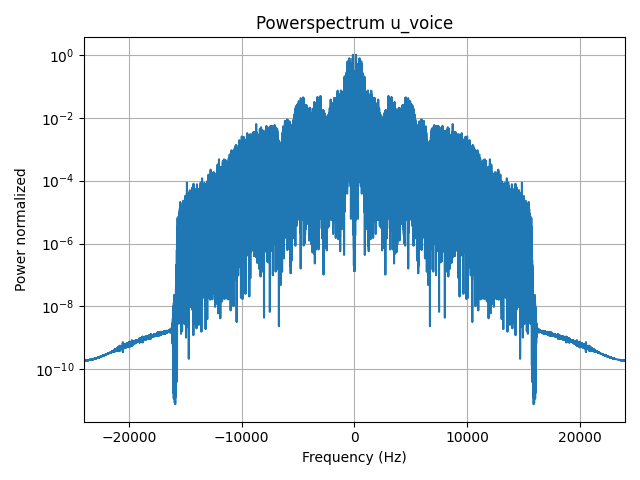

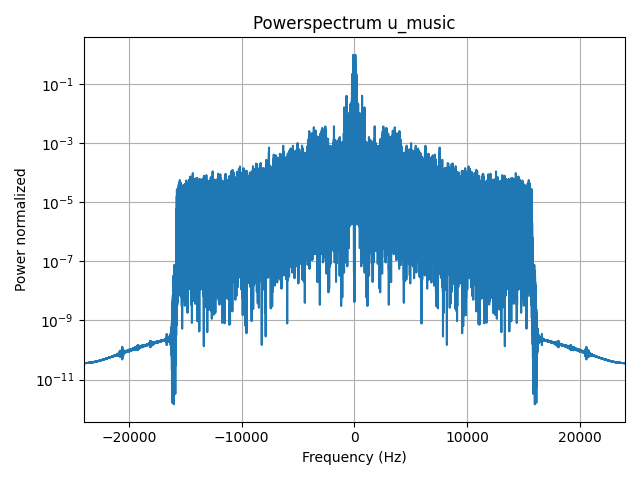

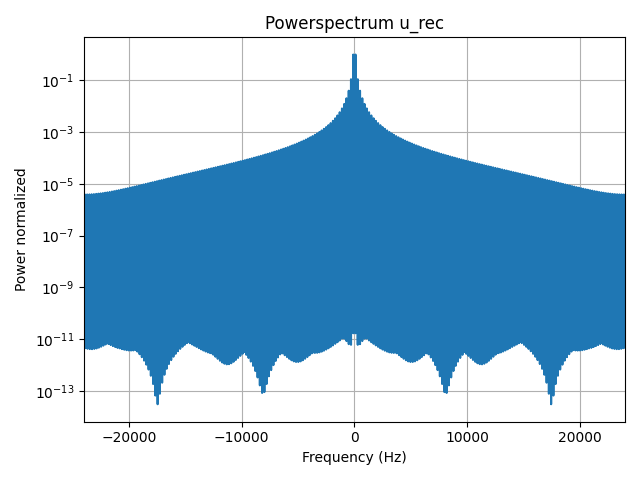

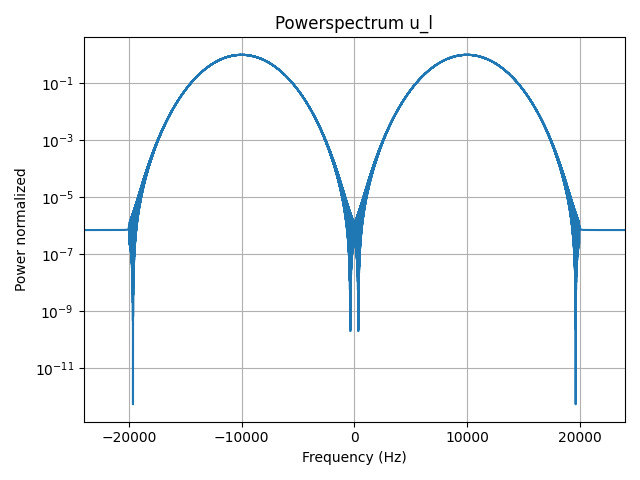

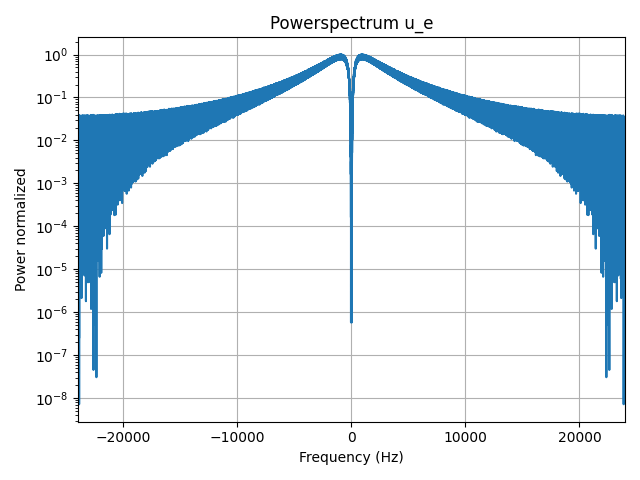

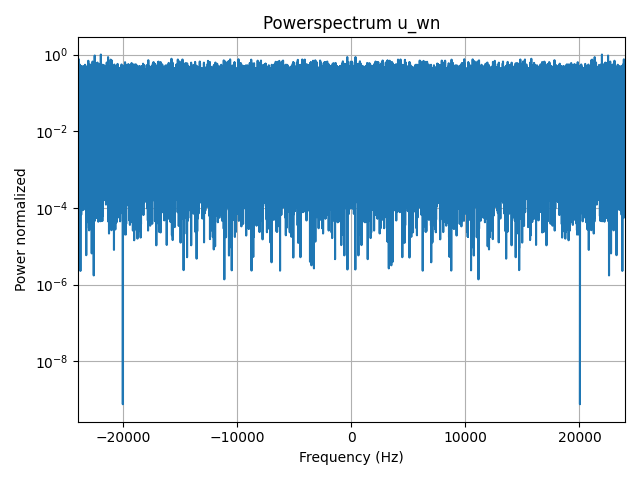

In [13]:
# calculate powerspectrum of the different input signals
f = np.fft.fftshift(np.fft.fftfreq(len(t), d=1/fs)) 
windowing = 1
for key, u in u_dict.items():
    if (key != "u_rec" or key != "u_wn") and windowing == 1:
        window = sp.windows.chebwin(len(u), 100) # windowing to reduce the spectral leakage
        u_win = u * window
    else:
        u_win = u
    U = np.fft.fft(u_win)
    R_u = (U * np.conj(U)) / len(u) # skaling to singal length
    R_u = np.fft.fftshift(np.abs(R_u))
    R_u /= np.max(R_u) # normalizing for better comparision
    plt.figure()
    plt.semilogy(f, R_u)
    plt.title(f"Powerspectrum {key}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power normalized")
    plt.grid(True)
    plt.xlim(-1/2*fs, 1/2*fs)
    plt.tight_layout()

# psds for voice makes no sense.... Voice has max frequency of 80000 Hz 


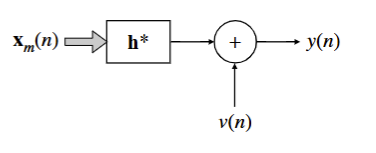

3.
for u_l 
h is a linear filter
1. calculate R = Exp{xx^H} matriz de correlacion de x (input)
2. calculate p = Exp{xy*} correlation crusada entre x e y
3. calculate w from Rw-p=0 => w = R^(-1)p! remember w = h


In [111]:
# Load the linear sweep in to python
x = u_l
y, f_lin = librosa.load(r"signals\Barrido lineal.wav", sr = fs) # has only 8 sec
# ERROR y.size < x.size
print("done")
fs = 48e3
# to work now: just cut
if(y.size>fs*duration):
    y = y[:int(fs*duration)]

print(x.size)
print(y.size)

done
480000
480000


In [112]:
from numpy.lib.stride_tricks import sliding_window_view
import scipy.linalg as la

# 1. calculate R = Exp{xx^H} matriz de correlacion de x (input)
# 2. calculate p = Exp{xy*} correlation crusada entre x e y
M=100
start = 500
x = x[start:start+M]
y = y[start:start+M]
X = np.fft.fft(x)
rxx = np.fft.ifft(X * np.conj(X))
Y = np.fft.fft(y)
rxy = np.fft.ifft(X * np.conj(Y))
rxx = la.toeplitz(rxx[:M])
print("rxy:")
print(rxy)
print("rxx:")
print(rxx)


rxy:
[-0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j
 -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j
 -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j
 -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j
 -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j
 -0.001-0.j -0.001-0.j -0.001+0.j -0.001-0.j -0.001-0.j -0.001-0.j
 -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j -0.001-0.j
 -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j
 -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001-0.j
 -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001-0.j
 -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j
 -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j
 -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j
 -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j -0.001+0.j
 -0.001+0.j -0.001+0.j -0.001+0.j -0.001-0.j -0.001-0.j -

In [14]:
# MSE J_o(M)
h = [] # regression vector (unknown parameter vector of the model) with dim(h) = m

J_o = var_v**2+(h.H*R_m*h-w_o.H*R*w_o)

NameError: name 'var_v' is not defined